## Setup for google colaboratory users
- If you use google colaboratory for your programming environment, please run the below. 
- You have to give a permission to refer the data in your google drive to import real data you have.

In [ ]:
# Mount Google Drive to read files in Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


- Change "TS" to your own folder name. (the folder where you save the data)

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

ch5_eng.ipynb  data_5_eng.xlsx


First, import the libraries.

In [ ]:
# Install the necessary libraries
!pip install -U statsmodels
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install neologdn
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver/usr/bin
#The code below is for displaying Japanese, install if you need.
#!pip install japanize_matplotlib

In [ ]:
# Code5.1
import csv
import glob
import os
import re
import time

import keras.initializers as initializers
import lightgbm as lgb
import MeCab
import neologdn
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D

#from keras.layers.recurrent import LSTM
from keras.layers import LSTM


from keras.models import Sequential
from mlxtend.regressor import StackingCVRegressor
from selenium import webdriver
from sklearn import ensemble, linear_model, svm, tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
#import tensorflow

In [ ]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
#import japanize_matplotlib

Then, load the data. We use the 219 series of Japan's monthly macroeconomics variables from Maehashi and Shintani (2020).

In [ ]:
# Code 5.2
# Load the data
rawdata = pd.read_excel("data_5_eng.xlsx", sheet_name="MS(JJIE2020)", header=[0])
msdata = rawdata.iloc[:, 1:]
dlen = len(msdata)
dti = pd.date_range("1974-01-01", periods=dlen, freq="MS")

Cross validation of time series data can be performed with the following code. The interval to reduce the correlation between training data and validation data is set to two months at "gap" in the code. In addition, according to the code, cross validation is carried out by means of expanding window type.

In [ ]:
# Code 5.3
PERIOD = 120  # Sample size of training data.（120 months）
H = 2  # Forecast horizon（2 months）
KF = 5  # K-fold（K=5）
data_y = pd.DataFrame(msdata.x204)
data_x = pd.DataFrame(msdata)
vsample, hsample = len(data_x), len(data_x.columns)

ex_x = data_x[0 : 0 + PERIOD]
ex_y = data_y[0 + H : 0 + H + PERIOD]
# K-fold cross validation
tscv = TimeSeriesSplit(n_splits=KF, gap=2)
for train_index, test_index in tscv.split(ex_x):
    train_xcv, test_xcv = ex_x.iloc[train_index, :], ex_x.iloc[test_index, :]
    train_ycv, test_ycv = ex_y.iloc[train_index], ex_y.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37] TEST: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57] TEST: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77] TEST: [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33

In [ ]:
#####
# AR forecast
predict_resultAR_list, sqe_resultAR_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）

predict_resultAR = np.zeros((vsample - H) - PERIOD)
sqe_resultAR = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_x = data_y[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # Test data
    test_x = data_y[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    # AR model
    model = linear_model.LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_resultAR[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_resultAR[i] = sqe

predict_resultAR_list.append(predict_resultAR)
sqe_resultAR_list.append(sqe_resultAR)

Lasso can bu computed with following code. We set grid numbers of tuning parameter to 100 at "N_LAMBDA" and set cross validation to 5-fold at "KF".

In [ ]:
# Code 5.4
# Lasso
predict_result1_list, sqe_result1_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # forecast horizon（12 months）
N_LAMBDA = 100  # Grid number of tuning parameters of penalty term
lasso_lambda = np.logspace(-2, 2, N_LAMBDA)
KF = 5  # K-fold（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Lasso estimation
    cvbox = np.zeros([KF, N_LAMBDA])
    for hpi in range(N_LAMBDA):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            lasso_cv = linear_model.Lasso(alpha=lasso_lambda[hpi], fit_intercept=True)
            model_cv = lasso_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = pd.DataFrame(np.average(cvbox, axis=0)).idxmin()
    op_lambda = lasso_lambda[op_hpi]
    lasso_best = linear_model.Lasso(alpha=op_lambda, fit_intercept=True)
    model_best = lasso_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result1_list.append(predict_result)
sqe_result1_list.append(sqe_result)

Ridge regression can be computed with the following code. Similarly, we set grid numbers of tuning parameter at "N_LAMBDA" and set cross validation to k-fold at "KF".

In [ ]:
# Code 5.5
# Ridge regression
predict_result2_list, sqe_result2_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon （12 months）
N_LAMBDA = 100  # Grid number of tuning parameters of penalty term
ridge_lambda = np.logspace(-2, 2, N_LAMBDA)
KF = 5  # K-fold（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Ridge regression estimation
    cvbox = np.zeros([KF, N_LAMBDA])
    for hpi in range(N_LAMBDA):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            ridge_cv = linear_model.Ridge(alpha=ridge_lambda[hpi], fit_intercept=True)
            model_cv = ridge_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = pd.DataFrame(np.average(cvbox, axis=0)).idxmin()
    op_lambda = ridge_lambda[op_hpi]
    ridge_best = linear_model.Ridge(alpha=op_lambda, fit_intercept=True)
    model_best = ridge_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result2_list.append(predict_result)
sqe_result2_list.append(sqe_result)

Elastic net can be computed with following code. "N\_LAMBDA" represents grid number of tuning parameters of penalty term, "N\_OMEGA" represents grid number of tuning parameters of the weight of $L_1$ norm and $L_2$ norm.

In [ ]:
# Code 5.6
# Elastic net
predict_result3_list, sqe_result3_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）
N_LAMBDA = 10  # Grid number of tuning parameters of penalty term
en_lambda = np.logspace(-2, 2, N_LAMBDA)
N_OMEGA = 11  # grid number of tuning parameters of the weight of  𝐿1  norm and  𝐿2  norm.
en_omega = np.linspace(0, 1, N_OMEGA)
KF = 5  # K-fold（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Elastic net estimation
    cvbox = np.zeros([KF, N_LAMBDA * len(en_omega)])
    for hpi in range(N_LAMBDA * len(en_omega)):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            en_cv = linear_model.ElasticNet(
                alpha=en_lambda[hpi // len(en_omega)],
                l1_ratio=en_omega[hpi % len(en_omega)],
                fit_intercept=True,
            )
            model_cv = en_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_alpha = en_lambda[op_hpi // len(en_omega)]
    op_ratio = en_omega[op_hpi % len(en_omega)]
    en_best = linear_model.ElasticNet(
        alpha=op_alpha, l1_ratio=op_ratio, fit_intercept=True
    )
    model_best = en_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result3_list.append(predict_result)
sqe_result3_list.append(sqe_result)

Summarizing the results of the regularized least squares estimator above, Figure 5.1 can be produced.

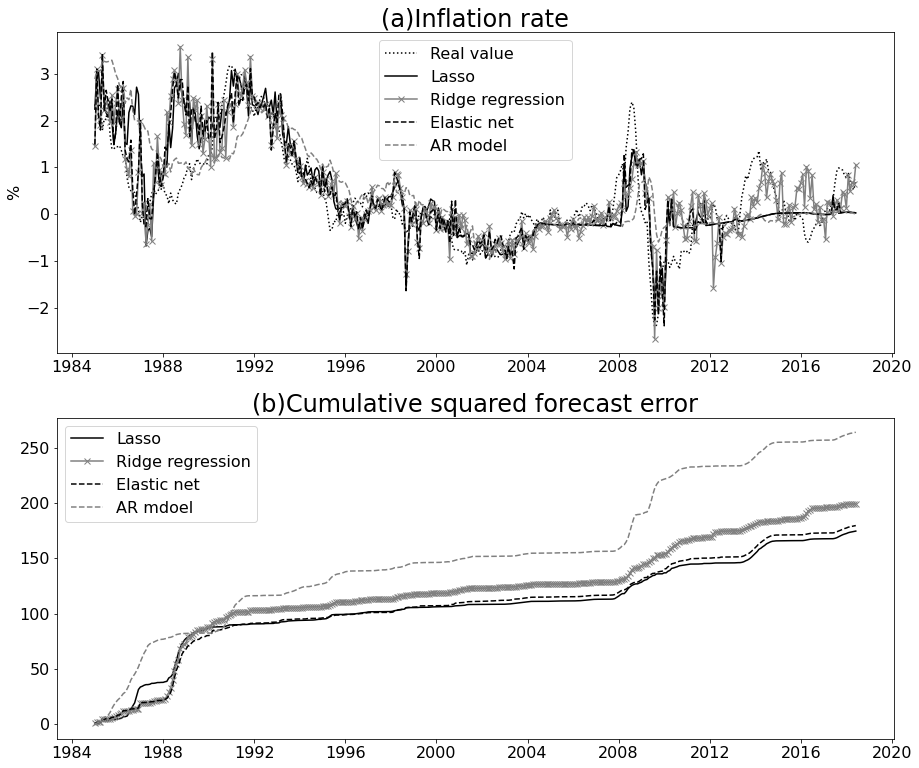

In [ ]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)Inflation rate", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result1_list), label="Lasso", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result2_list), label="Ridge regression", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result3_list), label="Elastic net", color="black", linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="AR model", color="grey", linestyle="dashed")
ax1.legend(loc="upper center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Cumulative squared forecast error", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result1_list).cumsum(), label="Lasso", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result2_list).cumsum(), label="Ridge regression", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result3_list).cumsum(), label="Elastic net", color="black", linestyle="dashed")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="AR mdoel", color="grey", linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

Linear SVR can be computed with following code.

In [ ]:
# Code 5.7
# SVR (Linear)
predict_result4_list, sqe_result4_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）
N_C = 16  # Grid number of tuning parameter "c"
svr_c = 2 ** np.linspace(-5, 10, N_C)
N_EPSILON = 11 # Grid number of tuning parameter "epsilon"
svr_epsilon = 2 ** np.linspace(-10, 0, N_EPSILON)
KF = 5  # K-fold（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # SVR estimation
    cvbox = np.zeros([KF, len(svr_c) * len(svr_epsilon)])
    for hpi in range(len(svr_c) * len(svr_epsilon)):
        tscv = TimeSeriesSplit(n_splits=KF, gap=4)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(
                kernel="linear",
                C=svr_c[hpi // len(svr_epsilon)],
                epsilon=svr_epsilon[hpi % len(svr_epsilon)],
            )
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_c = svr_c[op_hpi // len(svr_epsilon)]
    op_epsilon = svr_epsilon[op_hpi % len(svr_epsilon)]
    svr_best = svm.SVR(kernel="linear", C=op_c, epsilon=op_epsilon)
    model_best = svr_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)
    
predict_result4_list.append(predict_result)
sqe_result4_list.append(sqe_result)

Non-linear SVR can be computed with following code.

In [ ]:
# Code 5.8
# SVR（Non-linear）
predict_result4n_list, sqe_result4n_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon （12 months）
N_C = 16  # Grid number of tuning parameter "c"
svr_c = 2 ** np.linspace(-5, 10, N_C)
N_EPSILON = 11 # Grid number of tuning parameter "epsilon"
svr_epsilon = 2 ** np.linspace(-10, 0, N_EPSILON)
N_GAMMA = 31 # Grid number of tuning parameter "gamma"
svr_gamma = 2 ** np.linspace(-20, 10, N_GAMMA)
KF = 5  # K-fold（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Select the tuning parameter "gamma" so that the variance of the Gram matrix is maximized.
    np_train_x = np.array(train_x)
    variance_of_gram_matrix = list()
    for svr_gamma_temp in svr_gamma:
        gram_matrix = np.exp(
            -svr_gamma_temp * ((np_train_x[:, np.newaxis] - np_train_x) ** 2).sum(axis=2)
        )
        variance_of_gram_matrix.append(gram_matrix.var(ddof=1))
    op_svr_gamma = svr_gamma[
        np.where(variance_of_gram_matrix == np.max(variance_of_gram_matrix))[0][0]
    ]
    # Let tuning parameter "c" be the average of explained variable＋standard deviation×3
    op_svr_c = abs(np.average(train_y) + np.std(train_y) * 3)
    # SVR estimation
    cvbox = np.zeros([KF, len(svr_epsilon)])
    for hpi in range(0, len(svr_epsilon), 1):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(kernel="rbf", gamma=op_svr_gamma, C=op_svr_c, epsilon=svr_epsilon[hpi])
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_epsilon = svr_epsilon[op_hpi]
    cvbox = np.zeros([KF, len(svr_c)])
    for hpi in range(0, len(svr_c), 1):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(kernel="rbf", gamma=op_svr_gamma, C=svr_c[hpi], epsilon=op_epsilon)
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_c = svr_c[op_hpi]
    cvbox = np.zeros([KF, len(svr_gamma)])
    for hpi in range(0, len(svr_gamma), 1):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(kernel="rbf", gamma=svr_gamma[hpi], C=op_c, epsilon=op_epsilon)
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_gamma = svr_gamma[op_hpi]
    svr_best = svm.SVR(kernel="rbf", gamma=op_gamma, C=op_c, epsilon=op_epsilon)
    model_best = svr_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result4n_list.append(predict_result)
sqe_result4n_list.append(sqe_result)

Summarizing the results of SVR above, Figure 5.2 can be produced.

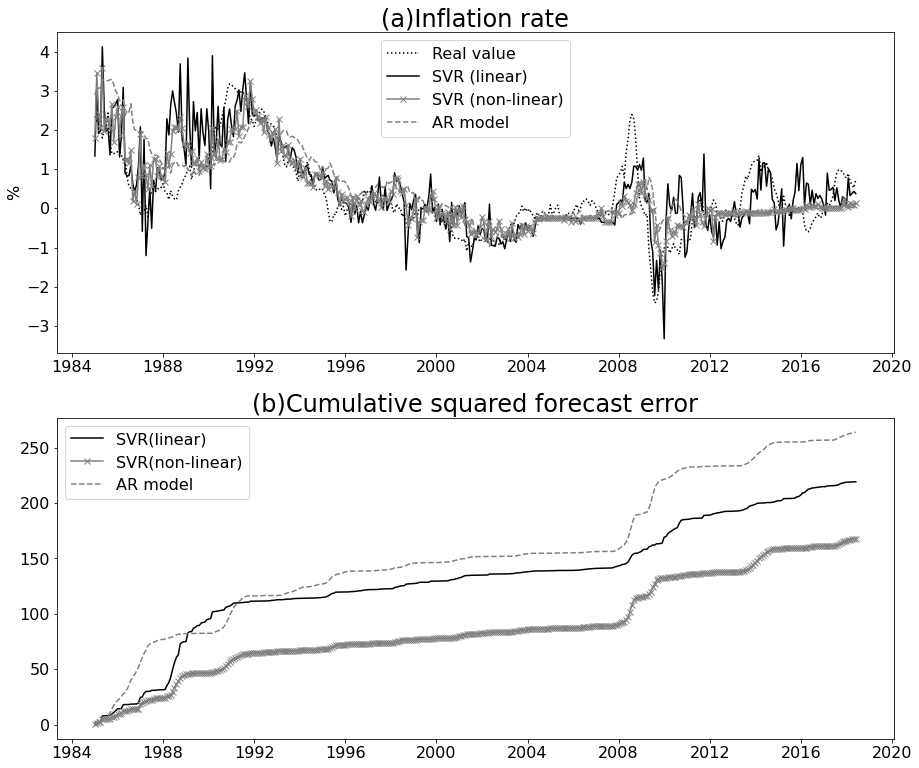

In [ ]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)Inflation rate", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result4_list), label="SVR (linear)", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result4n_list), label="SVR (non-linear)", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="AR model", color='grey', linestyle="dashed")
ax1.legend(loc="upper center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Cumulative squared forecast error", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result4_list).cumsum(), label="SVR(linear)", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result4n_list).cumsum(), label="SVR(non-linear)", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="AR model", color='grey', linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

Bagging can be computed with following code. We set the sample size of bootstrap to be 10 at "n_estimators".

In [ ]:
# Code 5.9
# Bagging
predict_result5_list, sqe_result5_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Bagging estimation
    model = ensemble.BaggingRegressor(
        base_estimator=tree.DecisionTreeRegressor(), n_estimators=10
    )
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result5_list.append(predict_result)
sqe_result5_list.append(sqe_result)

Random forest can be computed with following code. We set the number of predictors in the subset is set to be half of the total predictors at "max_samples"

In [ ]:
# Code 5.10
# Random forest
predict_result6_list, sqe_result6_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Random forest estimation
    model = ensemble.RandomForestRegressor(max_samples=0.5)
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result6_list.append(predict_result)
sqe_result6_list.append(sqe_result)

Boosting with lightGBM can be computed with following code. We set the learning rate to be 0.1 at "learning_rate".

In [ ]:
# Code 5.11
# Boosting（lightGBM）
predict_result7_list, sqe_result7_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Boosting estimation
    model = lgb.LGBMRegressor(learning_rate=0.1)
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result7_list.append(predict_result)
sqe_result7_list.append(sqe_result)

Stacking can be computed with following code. The first and second stage functions are specified in advance. In addition, according to the "StackingCVRegressor" code, the cross validation is set to be 5-fold.

In [ ]:
# Code 5.12
# Stacking
predict_result8_list, sqe_result8_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）
# First stage function
reg1 = linear_model.Lasso()
reg2 = linear_model.ElasticNet()
reg3 = svm.SVR()
reg4 = ensemble.BaggingRegressor()
reg5 = ensemble.RandomForestRegressor()
reg6 = lgb.LGBMRegressor()
# Second stage function
meta_model = linear_model.Ridge()

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # Stacking estimation
    model = StackingCVRegressor(
        regressors=[reg1, reg2, reg3, reg4, reg5, reg6], meta_regressor=meta_model
    )
    model.fit(np.array(train_x), np.array(train_y))
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result8_list.append(predict_result)
sqe_result8_list.append(sqe_result)

Summarizing the restults of regression tree and ensemble learning above, Figure 5.6 can be produced.

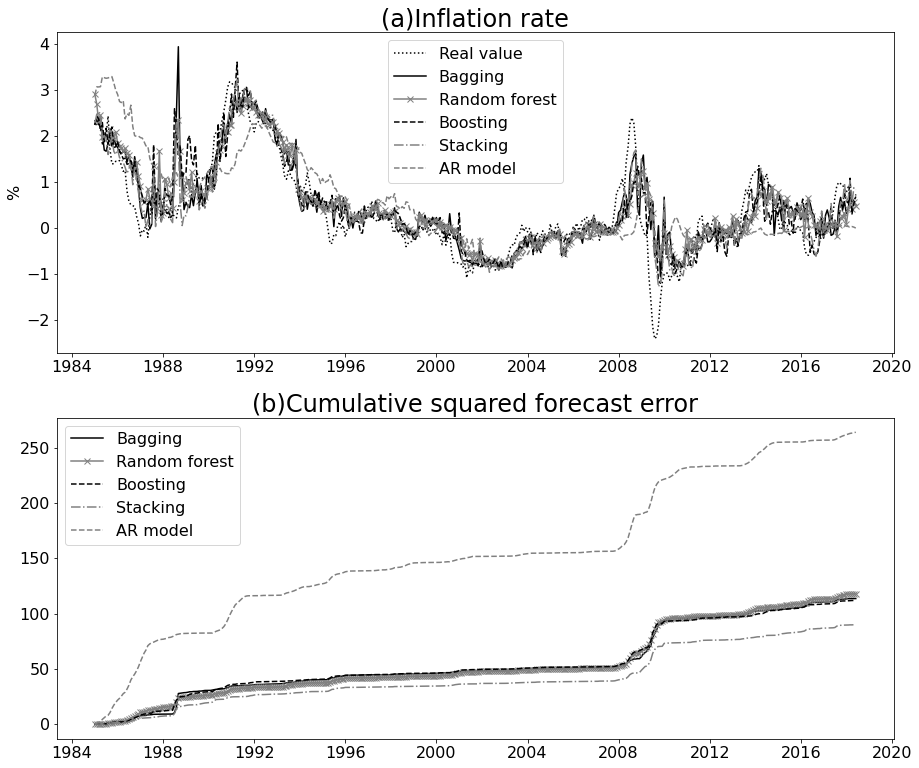

In [ ]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)Inflation rate", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result5_list), label="Bagging", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result6_list), label="Random forest", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result7_list), label="Boosting", color='black', linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result8_list), label="Stacking", color='grey', linestyle="dashdot")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="AR model", color='grey', linestyle="dashed")
ax1.legend(loc="upper center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Cumulative squared forecast error", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result5_list).cumsum(), label="Bagging", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result6_list).cumsum(), label="Random forest", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result7_list).cumsum(), label="Boosting", color='black', linestyle="dashed")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result8_list).cumsum(), label="Stacking", color='grey', linestyle="dashdot")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="AR model", color='grey', linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

FFNN can be computed with the following code. In addition, we can select the ReLU function at "activation function" , choosing "logistic" if it's sigmoid function, "tanh" if it's tahn function.

In [ ]:
# Code 5.13
# FFNN
predict_result9_list, sqe_result9_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # FFNN estimation
    nnet = MLPRegressor(
        activation="relu", hidden_layer_sizes=(32, 16, 8, 4, 2), solver="adam"
    )
    nnet.fit(train_x, train_y)
    forecast = nnet.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result9_list.append(predict_result)
sqe_result9_list.append(sqe_result)

CNN can be computed with following code. We set that there are 2 layers of convolution layer and 2 layers of pulling layer. In addition, By setting "kernel_initializer" to be "initializers.TruncatedNormal()", filter values in the convolution layer initialised with random numbers are trained using backpropagation, and "Flatten()" is a command that reorders the output of the previous pooling layer into a one-dimensional list, aggregating all coupled layers and finally calculating a single output value. In addition, "Dropout" is a peration that, randomly cuts the output from all the coupled layers by $10\%$ during the learning process using backpropagation, which serves to prevent overlearning.

In [ ]:
# Code 5.14
# CNN
def split_sequences(sequences, N_STEP):
    a_list, b_list = list(), list()
    for i in range(len(sequences)):
        end_ia = i + N_STEP
        if end_ia > len(sequences):
            break
        seq_a, seq_b = sequences[i:end_ia, :-1], sequences[end_ia - 1, -1]
        a_list.append(seq_a)
        b_list.append(seq_b)
    return np.array(a_list), np.array(b_list)


predict_result10_list, sqe_result10_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）
N_STEP = 12  # Lag order of CNN（12 months）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H - N_STEP) - PERIOD):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + N_STEP + i : H + N_STEP + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + N_STEP + i + PERIOD : H + N_STEP + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_x = scaler.transform(test_xx)
    exp1 = train_x
    dep1 = train_y.values
    dataset1 = np.append(exp1, dep1, axis=1)
    a_data, b_data = split_sequences(dataset1, N_STEP)
    n_features = a_data.shape[2]
    c_data = np.zeros([1, len(test_x.T)]).reshape(1, len(test_x.T))
    for j in range(0, N_STEP, 1):
        c_data = np.append(
            c_data, test_x[len(test_x) - (1 + j), :].reshape(1, len(test_x.T)), axis=0
        )
        c_data_adj = c_data[1:, :]
    d_data = c_data_adj.reshape((1, N_STEP, n_features))
    # CNN estimation
    model = Sequential()
    model.add(
        Conv1D(
            filters=8,
            kernel_size=3,
            padding="same",
            activation="relu",
            kernel_initializer=initializers.TruncatedNormal(),
            use_bias=True,
            input_shape=(N_STEP, n_features),
        )
    )
    model.add(MaxPooling1D(pool_size=2))
    model.add(
        Conv1D(
            filters=8,
            kernel_size=3,
            padding="same",
            activation="relu",
            kernel_initializer=initializers.TruncatedNormal(),
            use_bias=True,
        )
    )
    model.add(MaxPooling1D(pool_size=2))    
    model.add(Flatten())
    model.add(Dense(6, activation="relu"))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    model.fit(a_data, b_data, epochs=100)
    forecast = model.predict(d_data)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result10_list.append(predict_result)
sqe_result10_list.append(sqe_result)

RNN can be computed with following code. We set the unit number of hidden layers to be 32.

In [ ]:
# Code 5.15
# RNN
predict_result11_list, sqe_result11_list = [], []
PERIOD = 120  # Sample size of training data（120 months）
H = 12  # Forecast horizon（12 months）
N_STEP = 3  # Lag order of RNN （3 months）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range(0, (vsample - H - N_STEP) - PERIOD, 1):
    # Training data
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + N_STEP + i : H + N_STEP + i + PERIOD]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # Test data
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + N_STEP + i + PERIOD : H + N_STEP + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_x = scaler.transform(test_xx)
    exp1 = train_x
    dep1 = train_y.values
    dataset1 = np.append(exp1, dep1, axis=1)
    a_data, b_data = split_sequences(dataset1, N_STEP)
    n_features = a_data.shape[2]
    c_data = np.zeros([1, len(test_x.T)]).reshape(1, len(test_x.T))
    for j in range(0, N_STEP, 1):
        c_data = np.append(
            c_data, test_x[len(test_x) - (1 + j), :].reshape(1, len(test_x.T)), axis=0
        )
        c_data_adj = c_data[1:, :]
    d_data = c_data_adj.reshape((1, N_STEP, n_features))
    # RNN estimation
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_STEP, n_features)))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    model.fit(a_data, b_data, epochs=20)
    forecast = model.predict(d_data)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result11_list.append(predict_result)
sqe_result11_list.append(sqe_result)

Summarizing the results of neural network above, Figure 5.9 can be produced.

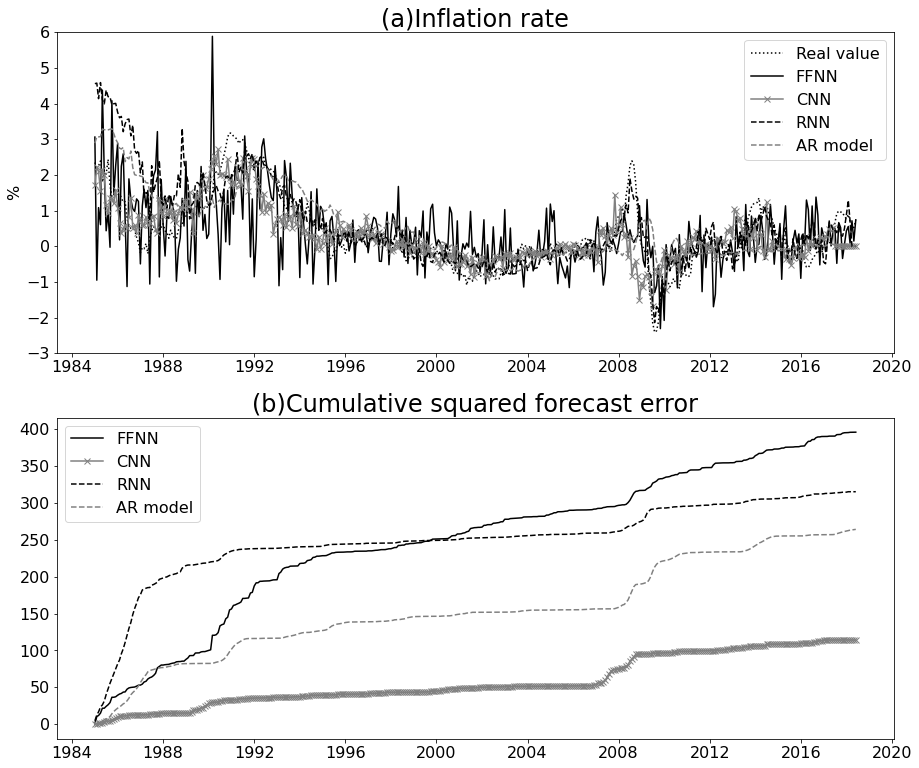

In [ ]:
#####
# Draw the graph
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)Inflation rate", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="Real value", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result9_list), label="FFNN", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result10_list), label="CNN", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result11_list), label="RNN", color='black', linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="AR model", color='grey', linestyle="dashed")
ax1.legend(loc="upper right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylim(-3, 6)
ax1.set_ylabel("%", fontsize=16)
ax2.set_title("(b)Cumulative squared forecast error", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result9_list).cumsum(), label="FFNN", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result10_list).cumsum(), label="CNN", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result11_list).cumsum(), label="RNN", color='black', linestyle="dashed")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="AR model", color='grey', linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)